1.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce

In [ ]:
%%capture
import os
import numpy as np

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display
import IPython.display as ipd

Audio preprocess for a single file

In [ ]:
# Define file path for a single file.
path = '/content/drive/MyDrive/SERdataset/Actor_02/03-01-01-01-01-01-02.wav'

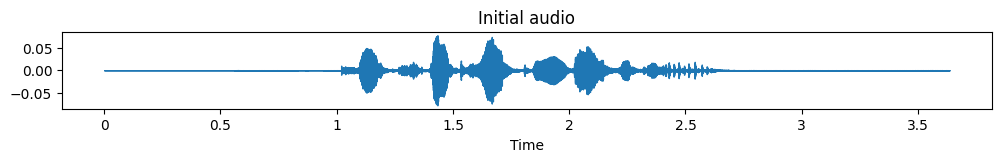

In [ ]:
# 1. Load the audio file into an 'AudioSegment' object, and extract the sample rate.
#    'x' is an array of samples that is only relevant for visualization at this part.

rawsound = AudioSegment.from_file(path)
x, sr = librosa.load(path, sr = None)

plt.figure(figsize=(12,1))
librosa.display.waveshow(x, sr=sr)
plt.title('Initial audio')

rawsound

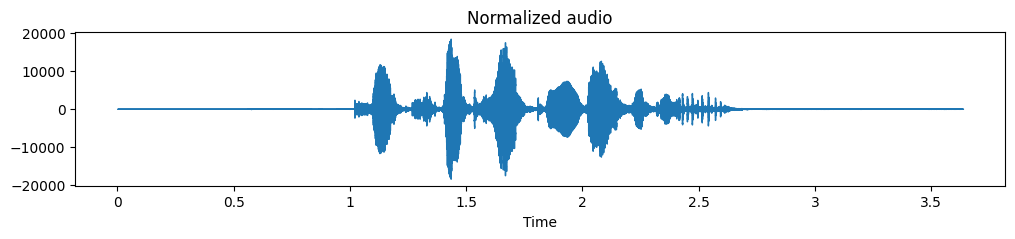

In [ ]:
# 2. Normalize to +5.0 dBFS, Transform audio signals to an array.

normalizedsound = effects.normalize(rawsound, headroom = 5.0)
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(12,2))
librosa.display.waveshow(normal_x, sr=sr)
plt.title('Normalized audio')

normalizedsound

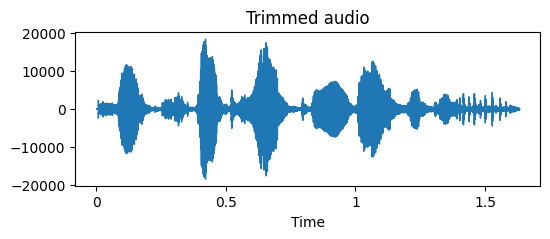

In [ ]:
# 3. Trim silence in the beginning and end.

xt, index = librosa.effects.trim(normal_x, top_db = 30)

plt.figure(figsize=(6,2))
librosa.display.waveshow(xt, sr=sr)
plt.title('Trimmed audio')

ipd.display(ipd.Audio(data = xt, rate=sr))

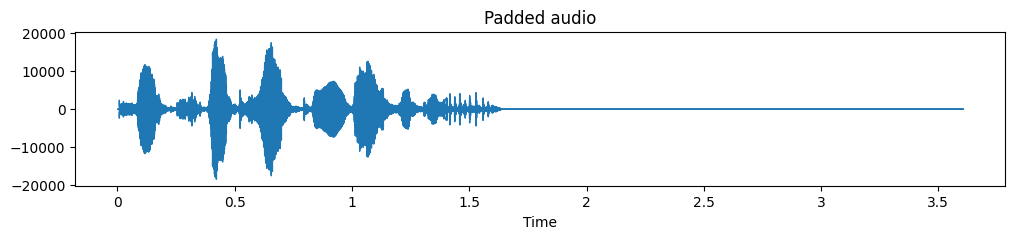

In [ ]:
# 4. Right-side padding for length equalization.
#    173056 = maximum lengthed audio (the extraction of this value is performed in the "SpeechEmotionRecognion_Model" notebook.)

padded_x = np.pad(xt, (0, 173056-len(xt)), 'constant')

plt.figure(figsize=(12,2))
librosa.display.waveshow(padded_x, sr=sr)
plt.title('Padded audio')

ipd.display(ipd.Audio(data = padded_x, rate=sr))

In [ ]:
padded_x.shape

(173056,)

Features extraction for a single file

In [ ]:
# Feature extraction

frame_length = 2048
hop_length = 512

f1 = librosa.feature.rms(y=padded_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square (RMS)
print('Energy shape:', f1.shape)
f2 = librosa.feature.zero_crossing_rate(padded_x, frame_length=frame_length, hop_length=hop_length) # Zero Crossed Rate (ZCR)
print('ZCR shape:', f2.shape)
f3 = librosa.feature.mfcc(y=padded_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length) # MFCCs
print('MFCCs shape:', f3.shape)

Energy shape: (1, 339)
ZCR shape: (1, 339)
MFCCs shape: (13, 339)


2.

In [ ]:
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
import numpy as np
import pandas as pd
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [ ]:
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
sample_lengths = []
folder_path = '/content/drive/MyDrive/SERdataset'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 204288


In [ ]:
import time

tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056  # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/SERdataset'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        # Fetch the sample rate.
        _, sr = librosa.load(path=os.path.join(subdir, file), sr=None)  # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.

        # Load the audio file.
        rawsound = AudioSegment.from_file(os.path.join(subdir, file))

        # Normalize the audio to +5.0 dBFS.
        normalizedsound = effects.normalize(rawsound, headroom=0)

        # Transform the normalized audio to np.array of samples.
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

        # Trim silence from the beginning and the end.
        xt, index = librosa.effects.trim(normal_x, top_db=30)

        # Check the length and pad or trim for duration equalization.
        if len(xt) < total_length:
            padded_x = np.pad(xt, (0, total_length - len(xt)), 'constant')
        else:
            padded_x = xt[:total_length]

        # Noise reduction.
        final_x = nr.reduce_noise(padded_x, sr=sr)  # updated 03/03/22

        # Features extraction
        f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)  # Energy - Root Mean Square
        f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length, center=True)  # ZCR
        f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)  # MFCC

        # Emotion extraction from the different databases
        if find_emotion_T(file) != "-1":  # TESS database validation
            name = find_emotion_T(file)
        else:  # RAVDESS database validation
            name = file[6:8]

        # Filling the data lists
        rms.append(f1)
        zcr.append(f2)
        mfcc.append(f3)
        emotions.append(emotionfix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic) / 60:0.4f} minutes")

if not rms:
    print("Warning: The 'rms' list is empty. Check if audio files are being processed correctly.")
if not zcr:
    print("Warning: The 'zcr' list is empty. Check if audio files are being processed correctly.")
if not mfcc:
    print("Warning: The 'mfcc' list is empty. Check if audio files are being processed correctly.")

Running time: 11.1395 minutes


In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
print(f_rms.shape)
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

(2880, 1, 339)
ZCR shape: (2880, 339, 1)
RMS shape: (2880, 339, 1)
MFCCs shape: (2880, 339, 13)


In [ ]:
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
x_data = X.tolist()
x_path = '/content/drive/MyDrive/Colab Notebooks/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[1], [2], [1], [1], [1], [2], [2], [2], [0], [1], [2], [2], [0], [1], [0], [1], [2], [0], [1], [3], [3], [3], [4], [4], [4], [3], [3], [3], [4], [2], [5], [4], [5], [3], [4], [3], [5], [4], [4], [5], [6], [5], [6], [5], [7], [7], [5], [6], [6], [6], [7], [6], [7], [7], [6], [6], [5], [7], [7], [7], [0], [1], [1], [2], [1], [1], [1], [0], [0], [0], [1], [1], [1], [3], [4], [2], [2], [2], [2], [3], [3], [2], [3], [4], [4], [4], [3], [3], [4], [3], [2], [4], [4], [3], [2], [4], [7], [6], [5], [6], [7], [7], [6], [6], [5], [6], [5], [7], [5], [6], [6], [5], [7], [5], [7], [7], [7], [5], [6], [5], [1], [0], [1], [2], [0], [1], [1], [0], [3], [1], [2], [1], [1], [3], [2], [2], [3], [2], [2], [3], [2], [2], [0], [1], [3], [3], [4], [3], [4], [5], [4], [5], [6], [5], [6], [5], [4], [4], [6], [4], [4], [3], [4], [6], [5], [5], [5], [6], [5], [7], [6], [7], [6], [7], [7], [7], [6], [7], [7], [7], [2], [2], [3], [2], [1], [1], [3], [2], [0], [2], [1], [0], [0], [2], [0], [3], [3], [1], [1], [1]

In [ ]:
x_path = '/content/drive/MyDrive/Colab Notebooks/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/MyDrive/Colab Notebooks/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(2520, 339, 15)
(250, 339, 15)
(110, 339, 15)


In [ ]:
file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[7], [3], [7], [5], [6], [2], [5], [5], [4], [7], [0], [4], [7], [2], [5], [5], [0], [4], [3], [6], [7], [7], [1], [4], [1], [6], [3], [6], [3], [4], [1], [1], [6], [4], [5], [7], [6], [3], [4], [3], [4], [2], [3], [4], [7], [7], [7], [6], [6], [2], [3], [5], [7], [6], [0], [5], [4], [5], [6], [4], [7], [6], [6], [1], [2], [1], [1], [7], [7], [6], [6], [4], [6], [5], [4], [1], [3], [1], [6], [6], [2], [3], [4], [6], [4], [7], [2], [1], [5], [4], [0], [5], [0], [1], [1], [2], [7], [0], [4], [1], [1], [6], [6], [1], [1], [2], [5], [2], [1], [5]], "dtype": "int8", "shape": [110, 1], "Corder": true}'

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks

In [ ]:
model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

# Compile & train
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=340, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 339, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/340
110/110 [==============================] - 48s 388ms/step - loss: 2.0022 - categorical_accuracy: 0.1869 - val_loss: 1.9782 - val_categorical_accuracy: 0.1840 - lr: 0.0010
Epoch 2/340


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 39s 352ms/step - loss: 1.9699 - categorical_accuracy: 0.1956 - val_loss: 1.9539 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/340
110/110 [==============================] - 37s 340ms/step - loss: 1.9654 - categorical_accuracy: 0.2052 - val_loss: 1.9468 - val_categorical_accuracy: 0.2440 - lr: 0.0010
Epoch 4/340
110/110 [==============================] - 39s 351ms/step - loss: 1.9617 - categorical_accuracy: 0.1980 - val_loss: 1.9759 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 5/340
110/110 [==============================] - 37s 339ms/step - loss: 1.9572 - categorical_accuracy: 0.2052 - val_loss: 1.9639 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 6/340
110/110 [==============================] - 37s 340ms/step - loss: 1.9554 - categorical_accuracy: 0.2060 - val_loss: 1.9631 - val_categorical_accuracy: 0.2440 - lr: 0.0010
Epoch 7/340
110/110 [==============================] - 40s 367ms/step - loss: 1.9538 - categorica

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

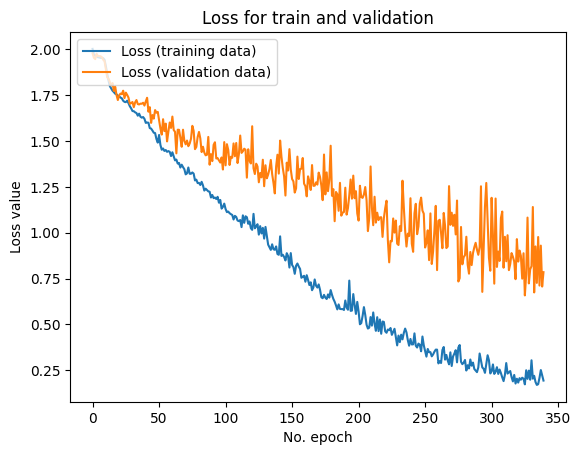

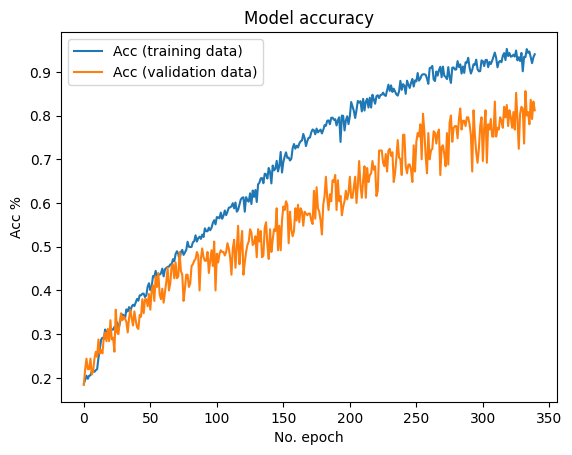

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

8/8 - 1s - loss: 0.6743 - categorical_accuracy: 0.8560 - 1s/epoch - 177ms/step


8/8 [==============================] - 5s 227ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

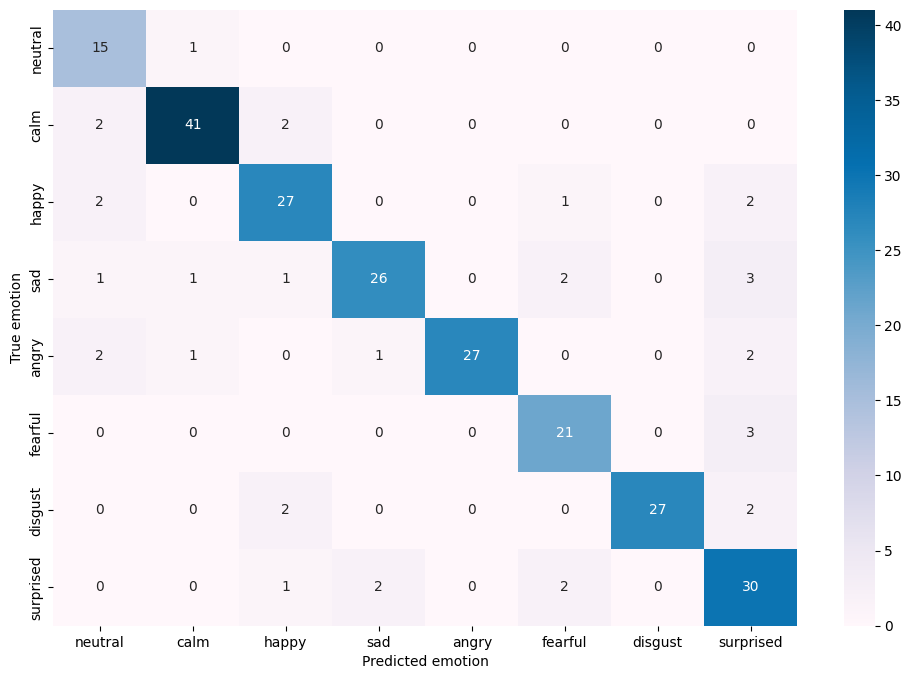

In [ ]:
y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.9375
calm : 0.9111
happy : 0.8438
sad : 0.7647
angry : 0.8182
fearful : 0.8750
disgust : 0.8710
surprised : 0.8571


In [ ]:
from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/MyDrive/Colab Notebooks/model8723_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


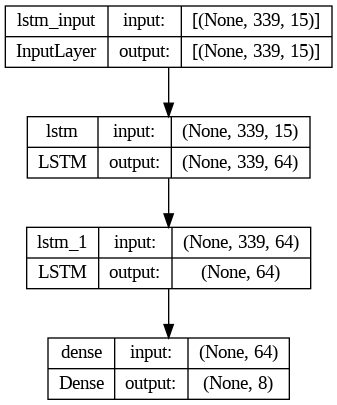

In [ ]:
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/MyDrive/Colab Notebooks/model8723_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

4/4 - 3s - loss: 0.6763 - categorical_accuracy: 0.8364 - 3s/epoch - 745ms/step


4/4 [==============================] - 4s 280ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

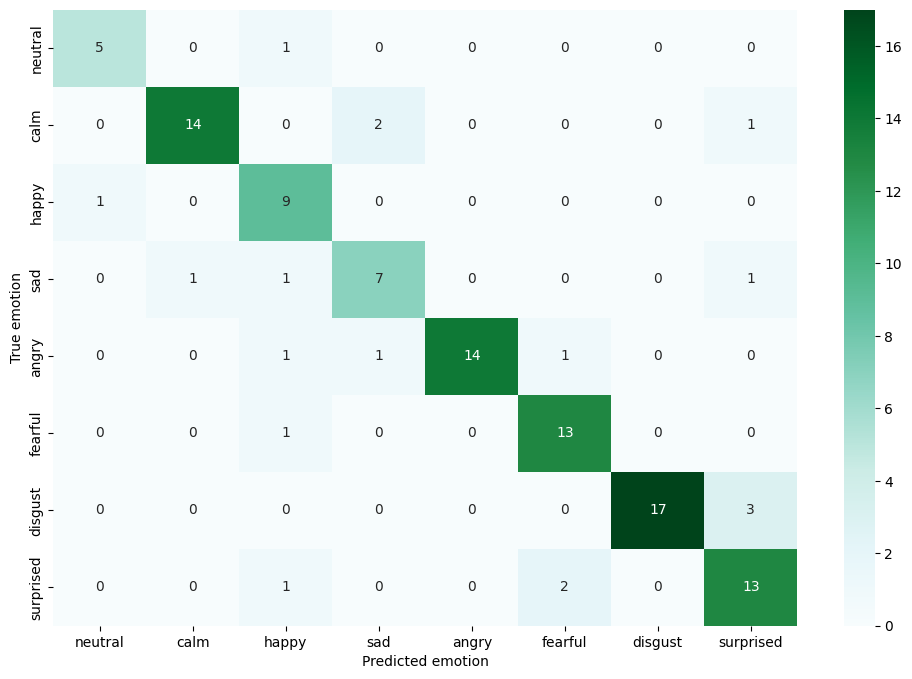

In [ ]:
y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.8333
calm : 0.8235
happy : 0.9000
sad : 0.7000
angry : 0.8235
fearful : 0.9286
disgust : 0.8500
surprised : 0.8125


3.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install pyaudio
!pip install json-tricks

In [ ]:
!apt-get install -y portaudio19-dev
!pip install pyaudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (138 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 123576 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.

In [ ]:
%%capture
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

import matplotlib.pyplot as plt

In [ ]:
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 339, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    '''
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None)
    # Normalize to 5 dBFS
    normalizedsound = effects.normalize(rawsound, headroom = 5.0)
    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Noise reduction
    final_x = nr.reduce_noise(normal_x, sr=sr, use_tensorflow=True)


    f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC
    X = np.concatenate((f1, f2, f3), axis = 1)

    X_3D = np.expand_dims(X, axis=0)

    return X_3D

In [ ]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install soundfile

<ipython-input-11-1099480b0a81>:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(WAVE_INPUT_FILE, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Playing the original audio file:


** session started
Playing segment from 0.00 to 7.10 seconds:


1/1 [==============================] - 2s 2s/step


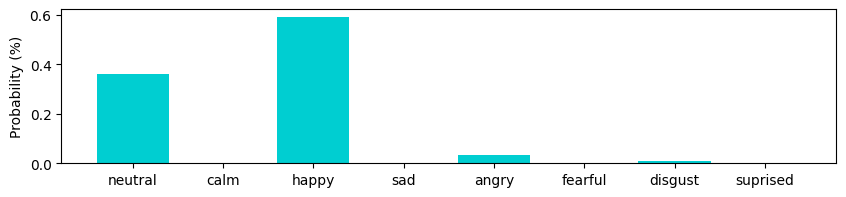

max emotion: happy
----------------------------------------------------------------------------------------------------
** session ended


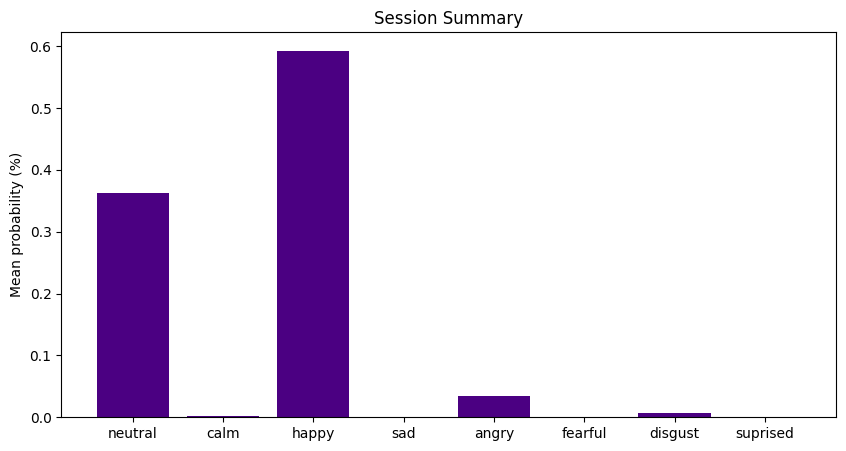

Emotions analyzed for: 6.4688 seconds


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import time
from IPython.display import Audio, display

# Correct the file path
WAVE_INPUT_FILE = "/content/drive/MyDrive/Recording (7).m4a"
RECORD_SECONDS = 7.1

# Function to check if the data is silent
def is_silent(data, threshold=0.01):
    return np.max(np.abs(data)) < threshold

# Function to preprocess the audio file
def preprocess(file_path, target_shape=(339, 15)):
    y, sr = librosa.load(file_path, sr=None)
    # Compute Mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=target_shape[1])
    log_S = librosa.power_to_db(S, ref=np.max)

    # Resize the spectrogram to match the target shape
    log_S = librosa.util.fix_length(log_S, size=target_shape[0], axis=1)

    # Transpose to match (time, features)
    log_S = log_S.T

    log_S = np.expand_dims(log_S, axis=-1)  # Add channel dimension
    return np.expand_dims(log_S, axis=0)  # Add batch dimension

# Function to get emotion name from prediction
def emotionfix(name):
    # Your emotion mapping code here
    pass

# Load the audio file
y, sr = librosa.load(WAVE_INPUT_FILE, sr=None)

# Play the original audio file
print("Playing the original audio file:")
display(Audio(WAVE_INPUT_FILE))

# SESSION START
print("** session started")
total_predictions = [] # A list for all predictions in the session.
tic = time.perf_counter()

# Segment the audio into chunks of RECORD_SECONDS duration
hop_length = int(RECORD_SECONDS * sr)
for start in range(0, len(y), hop_length):
    end = start + hop_length
    data = y[start:end]

    # Save the segmented audio to a temporary file
    temp_audio_path = '/content/drive/MyDrive/temp.wav'
    sf.write(temp_audio_path, data, sr)

    # Play the segmented audio
    print(f"Playing segment from {start/sr:.2f} to {end/sr:.2f} seconds:")
    display(Audio(temp_audio_path))

    x = preprocess(temp_audio_path) # 'temp.wav' file preprocessing.
    # Model's prediction => an 8 emotion probabilities array.
    predictions = model.predict(x, use_multiprocessing=True)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statements.
    total_predictions.append(pred_np)

    # Present emotion distribution for a sequence (7.1 secs).
    fig = plt.figure(figsize=(10, 2))
    plt.bar(emo_list, pred_np, color='darkturquoise')
    plt.ylabel("Probability (%)")
    plt.show()

    max_emo = np.argmax(predictions)
    print('max emotion:', emotions.get(max_emo, -1))

    print(100*'-')

    # Check if the segment is silent
    if is_silent(data):
        break

# SESSION END
toc = time.perf_counter()
print('** session ended')

# Present emotion distribution for the whole session.
total_predictions_np = np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize=(10, 5))
plt.bar(emo_list, total_predictions_np, color='indigo')
plt.ylabel("Mean probability (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")


<ipython-input-13-a38079998ce8>:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(WAVE_INPUT_FILE, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Playing the original audio file:


** session started
Playing segment from 0.00 to 7.10 seconds:


1/1 [==============================] - 0s 366ms/step


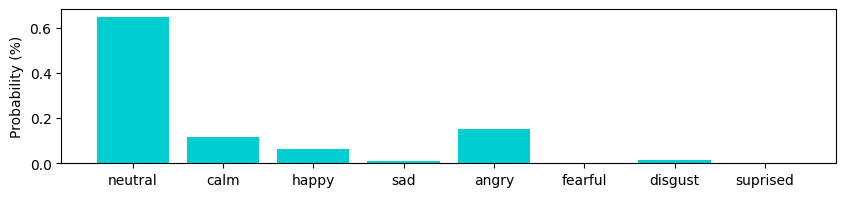

max emotion: neutral
----------------------------------------------------------------------------------------------------
** session ended


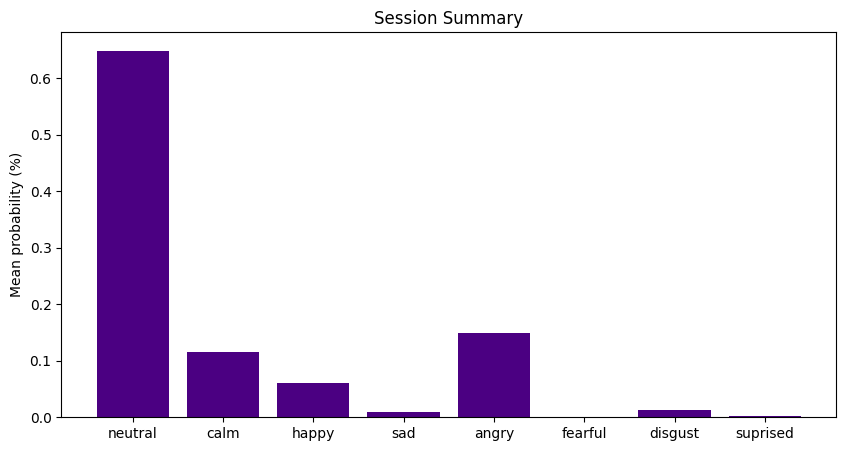

Emotions analyzed for: 2.1079 seconds


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import time
from IPython.display import Audio, display

# Correct the file path
WAVE_INPUT_FILE = "/content/drive/MyDrive/Recording (17).m4a"
RECORD_SECONDS = 7.1

# Function to check if the data is silent
def is_silent(data, threshold=0.01):
    return np.max(np.abs(data)) < threshold

# Function to preprocess the audio file
def preprocess(file_path, target_shape=(339, 15)):
    y, sr = librosa.load(file_path, sr=None)
    # Compute Mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=target_shape[1])
    log_S = librosa.power_to_db(S, ref=np.max)

    # Resize the spectrogram to match the target shape
    log_S = librosa.util.fix_length(log_S, size=target_shape[0], axis=1)

    # Transpose to match (time, features)
    log_S = log_S.T

    log_S = np.expand_dims(log_S, axis=-1)  # Add channel dimension
    return np.expand_dims(log_S, axis=0)  # Add batch dimension

# Function to get emotion name from prediction
def emotionfix(name):
    # Your emotion mapping code here
    pass

# Load the audio file
y, sr = librosa.load(WAVE_INPUT_FILE, sr=None)

# Play the original audio file
print("Playing the original audio file:")
display(Audio(WAVE_INPUT_FILE))

# SESSION START
print("** session started")
total_predictions = [] # A list for all predictions in the session.
tic = time.perf_counter()

# Segment the audio into chunks of RECORD_SECONDS duration
hop_length = int(RECORD_SECONDS * sr)
for start in range(0, len(y), hop_length):
    end = start + hop_length
    data = y[start:end]

    # Save the segmented audio to a temporary file
    temp_audio_path = '/content/drive/MyDrive/temp.wav'
    sf.write(temp_audio_path, data, sr)

    # Play the segmented audio
    print(f"Playing segment from {start/sr:.2f} to {end/sr:.2f} seconds:")
    display(Audio(temp_audio_path))

    x = preprocess(temp_audio_path) # 'temp.wav' file preprocessing.
    # Model's prediction => an 8 emotion probabilities array.
    predictions = model.predict(x, use_multiprocessing=True)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statements.
    total_predictions.append(pred_np)

    # Present emotion distribution for a sequence (7.1 secs).
    fig = plt.figure(figsize=(10, 2))
    plt.bar(emo_list, pred_np, color='darkturquoise')
    plt.ylabel("Probability (%)")
    plt.show()

    max_emo = np.argmax(predictions)
    print('max emotion:', emotions.get(max_emo, -1))

    print(100*'-')

    # Check if the segment is silent
    if is_silent(data):
        break

# SESSION END
toc = time.perf_counter()
print('** session ended')

# Present emotion distribution for the whole session.
total_predictions_np = np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize=(10, 5))
plt.bar(emo_list, total_predictions_np, color='indigo')
plt.ylabel("Mean probability (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")
